In [ ]:
#!pip install umap-learn
#!pip install yellowbrick
#!pip install pyLDAvis
#!pip install gensim

In [48]:
import pandas as pd
import pickle
from nltk.corpus import stopwords
import os

import string
import re
from nltk.stem import WordNetLemmatizer 

# visualization
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import NMF
from sklearn.cluster import KMeans 

# Probabilistic Modeling
from sklearn.decomposition import LatentDirichletAllocation
import gensim
from gensim import matutils, models
from gensim.corpora.dictionary import Dictionary
from gensim.models.coherencemodel import CoherenceModel
import scipy.sparse

import umap.umap_ as umap
from yellowbrick.text import UMAPVisualizer

import pyLDAvis
import pyLDAvis.gensim
import pyLDAvis.sklearn

import matplotlib.pyplot as plt

## Helper Functions

In [2]:
def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '", topic_names[ix], "'")
        print(", ".join([feature_names[i]
                         for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [3]:
def get_nmf_topics(model, n_top_words):
    #the word ids obtained need to be reverse-mapped to the words so we can print the topic names.
    feat_names = cv.get_feature_names()
    
    word_dict = {};
    for i in range(num_topics):
        
        #for each topic, obtain the largest values, and add the words they map to into the dictionary.
        words_ids = model.components_[i].argsort()[:-n_top_words - 1:-1]
        words = [feat_names[key] for key in words_ids]
        word_dict['Topic # ' + '{:02d}'.format(i+1)] = words;
    
    return pd.DataFrame(word_dict);

In [32]:
def processStopWords(text):  
    lemmatizer = WordNetLemmatizer()
    
    # remove punctuation
    table = str.maketrans('', '', string.punctuation)
    remove_punctuation = lambda x: x.translate(text)
    
    # remove numbers
    # text_nonum = lambda x: re.sub(r'\d+', '', x)
    text = [re.sub(r'\d+', '', x) for x in text]
    
    # convert all letters to lowercase
    # text_lower = lambda x: x.lower()
    text = [x.lower() for x in text]

    # substitute multiple spaces with single space
    # text_nospaces = lambda x: re.sub(r'\s+', ' ', x, flags=re.I)
    text = [re.sub(r'\s+', ' ', x, flags=re.I) for x in text]

    # remove all single characters
    # text_single = lambda x: re.sub(r'\s+[a-zA-Z]\s+', ' ', x)
    text = [re.sub(r'\s+[a-zA-Z]\s+', ' ', x) for x in text]
    
    # lemmatize words
    # lemmatize_tweet = lambda x: lemmatizer.lemmatize(x)
    text = [lemmatizer.lemmatize(x) for x in text]
    
#     for function in [remove_punctuation, 
#                      text_nonum, text_lower, text_nospaces, 
#                      text_single,
#                      lemmatize_tweet
#                     ]:
#         text = text.map(function)
    
    # split words that have spaces
    text = [y for x in text for y in x.split(' ')]
    return text

In [4]:
df = pd.read_csv(f'tweets/tweets_processed/coronavirus_california_tweets_processed', engine = 'python')

In [5]:
df['processed_text'] = df['processed_text'].values.astype(str)

## Vectorizer
* don't use TF-IDF for tweets, use CV because it's a small doc
* suggestion - binary = True ~ can throw in a lot of noise

In [6]:
cities = pickle.load(open('tweets/cities_list.txt', 'rb'))

In [33]:
stop_words = stopwords.words('english')
stop_words.extend(['coronavirus', 'covid', 'covidー', 'coronavirusoutbreak', 'coronaviruspandemic'])
stop_words.extend(list(cities['california']))
stop_words.extend(['california'])

stop_words = processStopWords(stop_words)
stop_words = set(stop_words)

In [100]:
num_topics = 5
index_names = [f'component_{x}' for x in range(num_topics)]
random_state = 42
n_gram = (2,2)
min_df = 3
max_df = 0.85

In [101]:
cv = CountVectorizer(analyzer='word',
                     min_df=min_df,
                     max_df=max_df,
                     ngram_range = n_gram,
                     stop_words=stop_words,
                     lowercase=True,
                     token_pattern='[a-zA-Z0-9]{3,}',
                     max_features=5000,
                     )
data_dtm = cv.fit_transform(df['processed_text'])

/opt/conda/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['blairsden', 'graeagle'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


## NMF

In [102]:
nmf_model = NMF(n_components = num_topics, random_state = random_state)
doc_topic_nmf = nmf_model.fit_transform(data_dtm)

topic_word_nmf = pd.DataFrame(nmf_model.components_.round(3),
                                  index=index_names,
                                  columns=cv.get_feature_names())

# doc_topic_nmf_chosen = performCustomNMF(tf, dtm, index_names = index_names)
#len(doc_topic_nmf_chosen)

In [109]:
display_topics(nmf_model, cv.get_feature_names(), 20, topic_names=None)


Topic  0
united state, state case, case united, across united, state response, york time, confirmed case, donald trump, president trump, state economy, state government, state via, back united, state testing, delay testing, testing set, set back, younger adult, state stock, everywhere already

Topic  1
stay home, home stay, home order, gavin newsom, gov gavin, wash hand, resident stay, people stay, californian stay, please stay, stay safe, ordered stay, newsom order, stop spread, home avoid, order californian, statewide stay, million people, home except, public health

Topic  2
test positive, tom hank, tested positive, player test, positive via, nba suspends, suspends season, hank test, hank wife, employee test, utah jazz, jazz player, wife test, rudy gobert, public health, season player, hank amp, wife tested, idris elba, kevin durant

Topic  3
social distancing, public health, practice social, practicing social, slow spread, health official, wash hand, flatten curve, county public, 

In [104]:
get_nmf_topics(nmf_model, 40)

,Topic # 01,Topic # 02,Topic # 03,Topic # 04,Topic # 05
0,united state,stay home,test positive,social distancing,toilet paper
1,state case,home stay,tom hank,public health,hand sanitizer
2,case united,home order,tested positive,practice social,buying toilet
3,across united,gavin newsom,player test,practicing social,roll toilet
4,state response,gov gavin,positive via,slow spread,buy toilet
5,york time,wash hand,nba suspends,health official,hoarding toilet
6,confirmed case,resident stay,suspends season,wash hand,paper shortage
7,donald trump,people stay,hank test,flatten curve,paper hand
8,president trump,californian stay,hank wife,county public,wash hand
9,state economy,please stay,employee test,healthcare system,panic buying


In [105]:
kmeans = KMeans(n_clusters=num_topics, random_state=random_state).fit(doc_topic_nmf)
cluster_topic_nmf = kmeans.labels_

/opt/conda/lib/python3.7/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../opt/conda/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))
/opt/conda/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 973 separate connected components using meta-embedding (experimental)
  n_components
/opt/conda/lib/python3.7/site-packages/umap/spectral.py:182: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  "WARNING: spectral initialisat

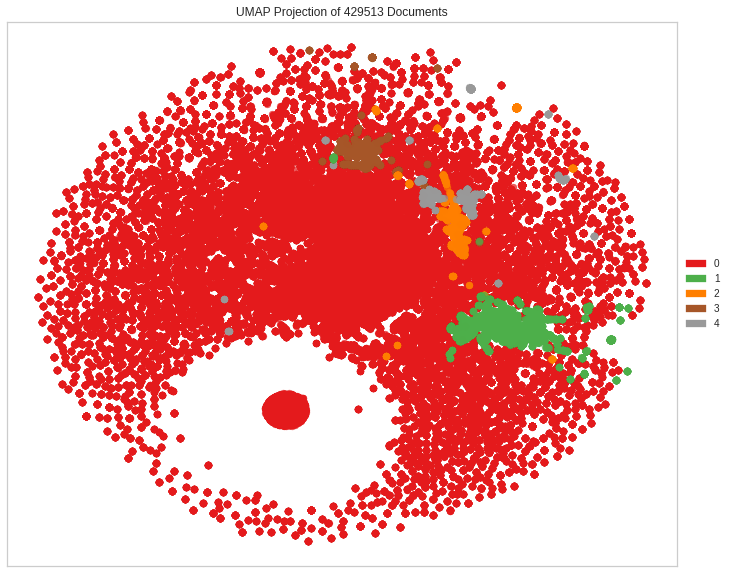

In [106]:
plt.figure(figsize=(15,10))
docs = doc_topic_nmf
labels = cluster_topic_nmf

umap = UMAPVisualizer(metric ='euclidean', colormap = 'Set1', random_state=42)
umap.fit(docs, labels)
umap.show()

## LDA
Topics generated from NMF are more coherent than LDA, so I've decided to use NMF.

In [107]:
# vectorizer = CountVectorizer(analyzer='word',
#                              min_df=min_df,
#                              max_df=max_df,
#                              stop_words=stop_words,
#                              lowercase=True,
#                              token_pattern='[a-zA-Z0-9]{3,}',
#                              max_features=5000,
#                              )

# data_vectorized = vectorizer.fit_transform(data_df['script'])
lda_model = LatentDirichletAllocation(n_components=num_topics,  # Number of topics
                                      learning_method='online',
                                      random_state=random_state,
                                      n_jobs=-1  # Use all available CPUs
                                      )
lda_output = lda_model.fit_transform(data_dtm)

display_topics(lda_model, cv.get_feature_names(), 40)


Topic  0
tom hank, trump administration, travel ban, amid fear, canceled due, stop spread, washing hand, joe biden, million people, via nyt, business insider, oil price, take care, every day, nba season, hank wife, utah jazz, public school, eerts say, due fear, trump address, last year, good thing, would like, shaking hand, hank test, movie theater, make sense, trump travel, whole thing, music festival, matt gaetz, help stop, health insurance, address nation, answer question, news conference, suspending season, could get, nba player

Topic  1
social distancing, stay home, donald trump, amid outbreak, sick leave, health official, work home, paid sick, two week, amid pandemic, prevent spread, working home, fox news, sign petition, get tested, world health, last week, health organization, rudy gobert, petition via, infectious disease, state emergency, trump say, week ago, payroll tax, get sick, high school, first time, trump response, president donald, community spread, county health, lo

In [108]:
pyLDAvis.enable_notebook()
pyLDAvis.sklearn.prepare(lda_model, data_dtm, cv, mds='tsne')

PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
1      150.222153  -72.269554       1        1  21.140893
2       51.163364 -159.968018       2        1  20.594252
4      -73.144554   21.523815       3        1  20.182823
3      -66.410133 -110.606438       4        1  19.225732
0       54.417324   12.443444       5        1  18.856300, topic_info=                 Term         Freq        Total Category  logprob  loglift
4619     united state  9037.000000  9037.000000  Default  30.0000  30.0000
4421         tom hank  4350.000000  4350.000000  Default  29.0000  29.0000
4278    test positive  4214.000000  4214.000000  Default  28.0000  28.0000
4413     toilet paper  4265.000000  4265.000000  Default  27.0000  27.0000
4288  tested positive  3853.000000  3853.000000  Default  26.0000  26.0000
...               ...          ...          ...      ...      ...      ...
1818        hank test   418.861211   419.658036   Topic5  -5.7119   1.6664
2664    movie theater   401.758666   402.553853   Topic5  -5.7535   1.6663
2486       make sense   395.961214   396.757653   Topic5  -5.7681   1.6663
4568     trump travel   385.187319   385.980771   Topic5  -5.7957   1.6663
4844      whole thing   383.668150   384.464107   Topic5  -5.7996   1.6663

[181 rows x 6 columns], token_table=      Topic      Freq           Term
term                                
88        4  0.999447   amid concern
90        5  0.999649      amid fear
94        1  0.999658  amid outbreak
95        1  0.999345  amid pandemic
164       4  0.997867    anyone else
...     ...       ...            ...
4873      1  0.999646      work home
4901      1  0.999339   working home
4909      1  0.999382   world health
4943      5  0.997975     would like
4981      3  0.999629      york time

[152 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 3, 5, 4, 1])

## Generate Models

In [90]:
state_list = ['california', 'colorado', 'florida',
              'georgia', 'idaho', 'illinois',
              'louisiana', 'massachusetts', 'newyork',
              'tennessee', 'texas', 'washington']

for state in state_list:
    if not os.path.exists(f'tweets/models/{state}'):
        os.makedirs(f'tweets/models/{state}')

In [142]:
def generateModel(state, remove_common=False):
    df = pd.read_csv(f'tweets/tweets_processed/coronavirus_{state}_tweets_processed', engine = 'python')
    df['processed_text'] = df['processed_text'].values.astype(str)
    
    
    stop_words = stopwords.words('english')
    stop_words.extend(['coronavirus', 'covid', 'covidー', 'coronavirusoutbreak', 'coronaviruspandemic'])
    stop_words.extend(list(cities[state]))
    
    stop_words.extend([state])

    
    if remove_common:
        stop_words.extend(['confirmed case', 'public health', 'president trump', 'live update',
                         'donald trump', 'tom hank', 'hank wife', 'utah jazz', 'rudy gobert',
                         'social distancing', 'test positive', 'positive via', 'health official',
                         'hank rita', 'case united', 'stay home', 'tested positive', 'jazz player',
                         'united state', 'across united', 'state health', 'wash hand', 'state case',
                         'state response', 'state via', 'player test', 'nba suspends',
                         'suspends season', 'state death', 'york time', 'state government',
                         'travel ban', 'spread united', 'employee test', 'death toll', 'wife rita',
                         'state testing', 'slow spread', 'season player', 'kevin durant',
                         'player tested', 'back united', 'people united', 'wife tested',
                         'hand sanitizer', 'state economy', 'update united', 'hospitalization united',
                         'stay safe', 'idris elba', 'brazilian official', 'official met', 'trump test',
                         'toilet paper', 'rita wilson', 'people tested', 'gobert tested',
                         'delay testing', 'set back', 'younger adult', 'state stock', 'travel europe',
                         'president donald', 'stop spread', 'wife test', 'member congress',
                         'practice social', 'practicing social', 'flatten curve', 'small business',
                         'washington post', 'wilson test', 'positive virus', 'say tested'])
        
    stop_words = processStopWords(stop_words)
    stop_words = set(stop_words)
    
    num_topics = 5
    index_names = [f'component_{x}' for x in range(num_topics)]
    random_state = 42
    n_gram = (2,2)
    min_df = 3
    max_df = 0.85
    
    n_top_words = 30
    
    cv = CountVectorizer(analyzer='word',
                     min_df=min_df,
                     max_df=max_df,
                     ngram_range = n_gram,
                     stop_words=stop_words,
                     lowercase=True,
                     token_pattern='[a-zA-Z0-9]{3,}',
                     max_features=5000,
                     )
    data_dtm = cv.fit_transform(df['processed_text'])
    
    nmf_model = NMF(n_components = num_topics, random_state = random_state)
    doc_topic_nmf = nmf_model.fit_transform(data_dtm)

    topic_word_nmf = pd.DataFrame(nmf_model.components_.round(3),
                                      index=index_names,
                                      columns=cv.get_feature_names())

    feat_names = cv.get_feature_names()
    
    word_dict = {};
    for i in range(num_topics):
        
        #for each topic, obtain the largest values, and add the words they map to into the dictionary.
        words_ids = nmf_model.components_[i].argsort()[:-n_top_words - 1:-1]
        words = [feat_names[key] for key in words_ids]
        word_dict[f'topic{i}'] = words;
    if remove_common:
        pickle.dump(word_dict, open(f'tweets/models/{state}/{state}_specific_topics.txt', 'wb'))
        pickle.dump(nmf_model, open(f'tweets/models/{state}/{state}_specific_model.pkl', 'wb'))
        pickle.dump(doc_topic_nmf, open(f'tweets/models/{state}/{state}_specific_doctopic.pkl', 'wb'))
    else:
        pickle.dump(word_dict, open(f'tweets/models/{state}/{state}_common_topics.txt', 'wb'))
        pickle.dump(nmf_model, open(f'tweets/models/{state}/{state}_common_model.pkl', 'wb'))
        pickle.dump(doc_topic_nmf, open(f'tweets/models/{state}/{state}_common_doctopic.pkl', 'wb'))
    print(f'{state} successfully dumped models and topics')

In [143]:
for state in state_list:
    generateModel(state)

/opt/conda/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['blairsden', 'graeagle'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


california successfully dumped models and topics
colorado successfully dumped models and topics
florida successfully dumped models and topics
georgia successfully dumped models and topics
idaho successfully dumped models and topics
illinois successfully dumped models and topics
louisiana successfully dumped models and topics
massachusetts successfully dumped models and topics
newyork successfully dumped models and topics
tennessee successfully dumped models and topics


/opt/conda/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['nas'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


texas successfully dumped models and topics
washington successfully dumped models and topics


In [141]:
for state in state_list:
    generateModel(state, remove_common=True)

/opt/conda/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['blairsden', 'graeagle'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


california successfully dumped models and topics
colorado successfully dumped models and topics
florida successfully dumped models and topics
georgia successfully dumped models and topics
idaho successfully dumped models and topics
illinois successfully dumped models and topics
louisiana successfully dumped models and topics
massachusetts successfully dumped models and topics
newyork successfully dumped models and topics
tennessee successfully dumped models and topics


/opt/conda/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['nas'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


texas successfully dumped models and topics
washington successfully dumped models and topics


## Common Topics Among States

In [93]:
from collections import Counter

topics_counter = Counter()

for state in state_list:
    state_topics = pickle.load(open(f'tweets/models/{state}/{state}_common_topics.txt', 'rb'))
    for topics in state_topics:
        topics_counter += Counter(state_topics[topics])

In [95]:
common_stop = [x[0] for x in topics_counter.most_common() if x[1] > 5]

In [96]:
import pprint
pp = pprint.PrettyPrinter(compact = True)
pp.pprint(common_stop)

['confirmed case', 'public health', 'president trump', 'live update',
 'donald trump', 'tom hank', 'hank wife', 'utah jazz', 'rudy gobert',
 'social distancing', 'test positive', 'positive via', 'health official',
 'hank rita', 'case united', 'stay home', 'tested positive', 'jazz player',
 'united state', 'across united', 'state health', 'wash hand', 'state case',
 'state response', 'state via', 'player test', 'nba suspends',
 'suspends season', 'state death', 'york time', 'state government',
 'travel ban', 'spread united', 'employee test', 'death toll', 'wife rita',
 'state testing', 'slow spread', 'season player', 'kevin durant',
 'player tested', 'back united', 'people united', 'wife tested',
 'hand sanitizer', 'state economy', 'update united', 'hospitalization united',
 'stay safe', 'idris elba', 'brazilian official', 'official met', 'trump test',
 'toilet paper', 'rita wilson', 'people tested', 'gobert tested',
 'delay testing', 'set back', 'younger adult', 'state stock', 'travel 